In [7]:
import openslide
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from scipy.stats import mstats
from functools import reduce
from operator import mul
import os
import glob
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 5, 5

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [8]:
"""
Helper functions.
"""

def closestLevel(levelDims,w):
    differences = map(lambda dim: (abs(dim[1]-w), abs(dim[1]-w)),levelDims)
    areas = map(lambda levelDims: reduce(mul,levelDims),(differences))
    level = [idx for idx,area in enumerate(areas) if area == min(areas)][0]
    return level


def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    return (arr.reshape(h/int(nrows), nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

def pad(arr,windowSize):
    
    """
    Pads array to be divisible by window size.
    """
    
    divisible = False
    while divisible == False:
        if  arr.shape[0] % windowSize != 0:
            arr = np.pad(arr,((0,2),(0,0)),"constant")
        if  arr.shape[1] % windowSize != 0:
            arr = np.pad(arr,((0,0),(0,2)),"constant")

        if all([dim % windowSize ==0 for dim in arr.shape])==True:
                divisible = True
    return arr

def getBoxCoords(blocksPair,level,upscaleLevel):
    
    """
    Returns information to load region of high resolution image. Given indicies blocks for x and y,
    low resolution image level and desired output level.
    """
    x = blocksPair[1]
    x1 = x[0][0] -1 
    x2 = x[0][-1]
    y = blocksPair[0]
    y1 = y[0][0] -1 
    y2 = y[-1][0]
    #print("X",x1,x2)
    #print("Y",y1,y2)
    upscaledX0 = map(lambda coord: np.power(2,level)*coord, (x1,x2)) #Level 0 x coords needed for region initial value
    upscaledY0 = map(lambda coord: np.power(2,level)*coord, (y1,y2)) #Level 1 y coords needed for region initial value
    location = (upscaledX0[0],upscaledY0[0])
    upscaledX = map(lambda coord: np.power(2,level-upscaleLevel)*coord, (x1,x2))
    upscaledY = map(lambda coord: np.power(2,level-upscaleLevel)*coord, (y1,y2))
    size = ((upscaledX[1] - upscaledX[0]),(upscaledY[1] - upscaledY[0]))
    return location, size, ((x1,x2),(y1,y2))

percentage255 = lambda block: np.sum(block==255).astype("float64")/block.size # Calculates percentage of array = 255.

def removeFiles(path):
    """
    Remove all files in a path.
    """
    files = glob.glob(path+"*")
    for f in files:
        os.remove(f)
        
    
#Remove black
def removeBlack(img,blackThresh):
    img
    black = np.logical_and.reduce((img[:,:,0] > blackThresh,
                                   img[:,:,1] > blackThresh,
                                   img[:,:,2] > blackThresh, 
                                   img[:,:,3] > blackThresh))
    black4 = np.dstack([black for i in range(3)])
    img[np.logical_not(black4)] = mstats.mode(img[:,:,:3],axis=None)[0]

In [9]:
from scipy import ndimage

def getBlobs(img,thresh,show=0):
    blobs, numberOfBlobs = ndimage.label(img)
    objs = ndimage.find_objects(blobs)
    significantObjects = []
    for i in range(len(objs)):
        obj = objs[i]
        area = (obj[0].stop - obj[0].start)*(obj[1].stop - obj[1].start)

        if float(area)/img.size > thresh:
            significantObjects.append(obj)
            if show == 1:
                plt.imshow(img[obj])
                plt.show()
    if len(significantObjects)==0:
        return getBlobs(img,thresh-0.01)
    else:
        return significantObjects


def templateMatch(img,templateImg,areaThresh,angleInterval,methodStr):
    method = eval(methodStr)
    templates = getBlobs(templateImg,areaThresh,0)
    boxes = []
    img2 = img.copy()
    #plt.imshow(img,cmap=cm.gray)
    #plt.show()
    #plt.imshow(templateImg,cmap=cm.gray)
    #plt.show()
    # For every template in our set of templates
    for temp in templates:

        print("Template %d out of %d"%(templates.index(temp)+1,len(templates)))
        #plt.imshow(templateImg[temp],cmap=cm.gray)
        #plt.show()
        
        bestRotationAngle = 0
        highestMaxVal = 0
        bestCoords = None
        
        # Rotate each template throughout 360 to find best match based on maximum value generated by match template
        for angle in np.arange(0,360,angleInterval):
            
            dst = ndimage.rotate(templateImg[temp], angle) # dst is new name for rotated template
            
            (wImg,hImg),(wDst,hDst) = img.shape[::-1], dst.shape[::-1]
            if wImg < wDst:
                wDiff = wDst - wImg
                dst = dst[wDiff/2:(wDst-wDiff/2-1)]
                #print("too wide %d < %d" %(wImg,wDst))
                #print(dst.shape)
            if hImg < hDst:
                hDiff = hDst - hImg
                dst = dst[hDiff/2:(hDst-hDiff/2-1)]
                #print("too tall %d < %d" %(hImg,hDst))
                #print(dst.shape)
            
            w, h = dst.shape[::-1]
            
            ##.imshow(dst,cmap=cm.gray)
            #plt.title("Angle of %d" % angle)
            #plt.show()
            
            try:
                # Apply template matching
                res = cv2.matchTemplate(img2,dst,method)
                minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(res)
                if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
                    topLeft = minLoc
                else:
                    topLeft = maxLoc
                bottomRight = (topLeft[0] + w, topLeft[1] + h)
                if maxVal > highestMaxVal:
                    bestCoords = (topLeft,bottomRight,w,h)
                    highestMaxVal = maxVal
                    bestRotationAngle = angle
                    bestRes = res
            except:
                pass
            
            
        #cv2.rectangle(img2,bestCoords[0], bestCoords[1], 255, 20)
        boxes.append({"topLeft":bestCoords[0],"w":bestCoords[2],"h":bestCoords[3]})
        #plt.imshow(bestRes,cmap=cm.gray)
        #plt.show()
        #plt.imshow(img2,cmap=cm.gray)
        #plt.show()
        
    # Make thresholded image
    mask = np.zeros(img2.shape,np.uint8)
    for box in boxes:
        topLeft = box.get("topLeft")
        w = box.get("w")
        h = box.get("h")
        mask[topLeft[1]:topLeft[1]+h,topLeft[0]:topLeft[0]+w] = img2[topLeft[1]:topLeft[1]+h,topLeft[0]:topLeft[0]+w]

    plt.imshow(mask,cmap=cm.gray)
    plt.show()
    return mask


In [10]:
"""
Main image object.
"""

class her2Image():
    def __init__(self,caseNumber,threshArea,threshMargin,upscaleWindowSize,upscaleLevel,blackThresh,blurSize,test,method):
        
        case = groundTruth.loc[groundTruth.CaseNo==caseNumber]
        self.score, self.percScore = case["HeR2 SCORE"].values[0], case["PERCENTAGE CELLS WITH COMPLETE MEMBRANE STAINING IRRESPECTIVE OF INTENSITY"].values[0]

        if train == 1:
            path = "data/"  
        else:
            path = "testData/"  

        self.her2 = openslide.open_slide(path+str(caseNumber)+'_HER2.ndpi') # Main image object in wdi format
        self.he = openslide.open_slide(path+str(caseNumber)+'_HE.ndpi')
        #self.he = openslide.open_slide('data/'+str(caseNumber)+'_HE.ndpi')
        self.nLevels = self.her2.level_count # Number of levels
            
        #self.level = closestLevel(self.her2.level_dimensions,1000)
        self.level = 7
        self.lowResDims,self.lowResDimsHE = [x.level_dimensions[self.level] for x in [self.her2,self.he]] #3 is arbitrary but works
        self.lowResRGB, self.lowResRGBHE = [np.asarray(x[0].read_region((0,0),
                    self.level,(x[1][0],x[1][1]))).copy() for x in [(self.her2,self.lowResDims),
                                                                                          (self.he,self.lowResDimsHE)]] 


        #[removeBlack(img,blackThresh) for img in [self.lowResRGB,self.lowResRGBHE]]
        
        
        self.lowRes, self.lowResHE = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in self.lowResRGB, self.lowResRGBHE]  # Grayscale
        self.mode, self.modeHE = [mstats.mode(img,axis=None)[0] for img in [self.lowRes, self.lowResHE]]
        
        # Thresholded image
        def thresh(img,threshMargin,blurSize):
            img = cv2.GaussianBlur(img,(blurSize,blurSize),0)
            _,thresh = cv2.threshold(img,mstats.mode(img,axis=None)[0]-threshMargin,255,1)
            #thresh = cv2.GaussianBlur(thresh,(blurSize,blurSize),0)
            return thresh
        self.thresh, self.threshHE = [thresh(img,threshMargin,blurSize) for img in [self.lowRes, self.lowResHE]]
        
        self.thresh = templateMatch(self.thresh,self.threshHE,0.05,angleInterval = 3,methodStr=method)
        
        # Padd lowRes image and thresholded to make factors
        nrows = ncols = upscaleWindowSize/np.power(2,self.level-upscaleLevel)
        
        self.lowRes, self.thresh = [pad(arr,nrows) for arr in (self.lowRes, self.thresh)]
        
        coordsX,coordsY = np.indices((self.lowRes.shape[0],self.lowRes.shape[1]))
        blocksX,blocksY = blockshaped(coordsX,nrows,ncols),blockshaped(coordsY,nrows,ncols)
        blocksThresh = blockshaped(self.thresh,nrows,ncols)
        blocksLowRes = blockshaped(self.lowRes,nrows,ncols)

        self.relaventCoords = [] # ROIs

        #featureBlocks = np.where(np.any(blocksThresh==255,axis=(1,2)))[0]
        featureBlocks = np.where(np.array([percentage255(block) for block in blocksThresh])>threshArea)[0] # Percentage covered
        for block in featureBlocks:
            self.relaventCoords.append((blocksX[block],blocksY[block]))
        
    def show(self):
        
        plt.imshow(self.lowResRGB)
        plt.title(("Mode = %d, score = %d and percScore = %d." % (self.mode,self.score,self.percScore)))
        plt.show()
        plt.imshow(self.lowResRGBHE)
        plt.title(("Mode = %d, score = %d and percScore = %d." % (self.mode,self.score,self.percScore)))
        plt.show()
        plt.imshow(self.thresh,cmap=cm.gray)
        plt.show()
             
    def regionGen(self,upscaleLevel,colour=False): 
        for i in range(len(self.relaventCoords)):
            location, size, ((x1,x2),(y1,y2)) = getBoxCoords(self.relaventCoords[i],self.level,upscaleLevel)
            if colour==True:
                thickness = 20
            else:
                thickness = 2
            cv2.rectangle(self.lowResRGB, (x1, y1), (x2, y2), (255,0,0), thickness)
            region = np.asarray(eg.her2.read_region((location[0],location[1]),upscaleLevel,(size[0],size[1])))
            yield region
            


In [11]:
# Hyperparams
numberOfRegions = []
imagesWithLines = [84,82,35]

train = True
threshArea = 0.02
threshMargin = 2
save = 0
show = 1
displayProb = 0.00
blackThresh = 120
blurSize = 77
upscaleLevels = [4]
upscaleLevel = 5
upscaleWindowSize = np.power(2,12-upscaleLevel)


if train == True:
    groundTruth = pd.read_csv("data/groundTruth.csv")
    writePath = "/home/msmith/her2/data/"
else:
    groundTruth = pd.read_csv("testData/groundTruth.csv")
    writePath = "/home/msmith/her2/testData/"

cols = {1: "CaseNo", 2: "HeR2 SCORE",
       3:"PERCENTAGE CELLS WITH COMPLETE MEMBRANE STAINING IRRESPECTIVE OF INTENSITY"}

methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

method = methods[1]

#Filter model params
def filterPaths ():
    writePath = "/home/msmith/her2/filter/data/"
    upscaleLevels = [5]
    threshArea = 0.25
    threshMargin = -40

Upscale level 4
Template 1 out of 2
Template 2 out of 2


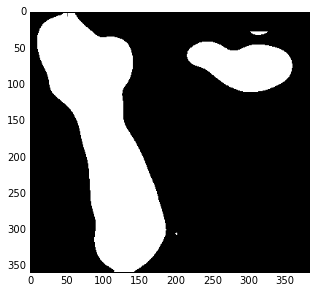

Image 1 with score of 0, percScore of 0. Region sizes generated 256.


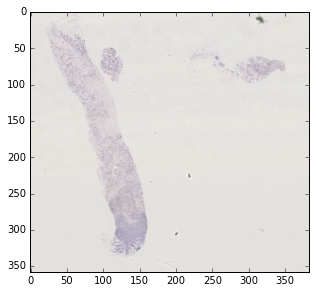

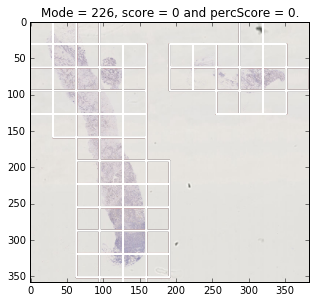

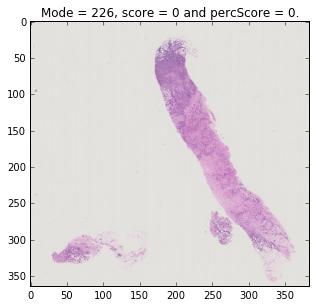

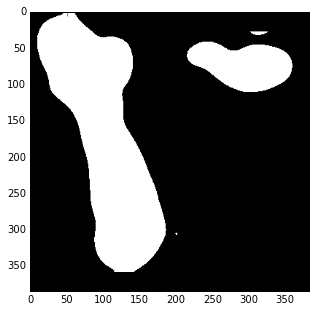

Number of regions generated at level 7 = 62 with dimension 256 x 256 x 3.
Template 1 out of 2
Template 2 out of 2


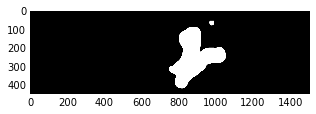

Image 4 with score of 2, percScore of 60. Region sizes generated 256.


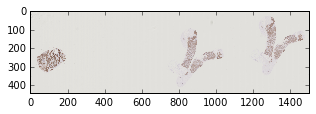

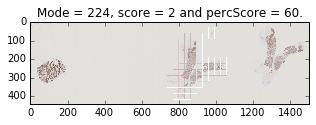

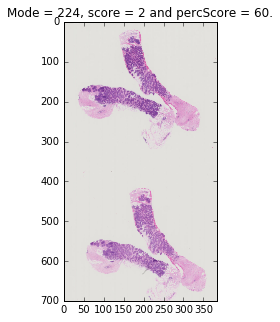

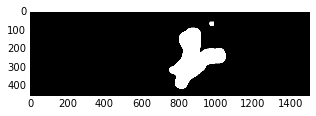

Number of regions generated at level 7 = 62 with dimension 256 x 256 x 3.
Template 1 out of 1


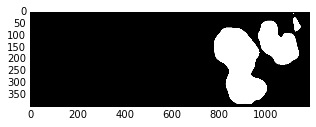

Image 6 with score of 2, percScore of 40. Region sizes generated 256.


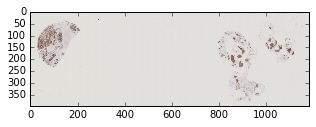

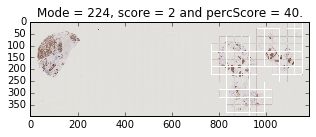

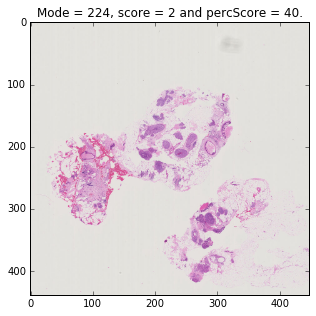

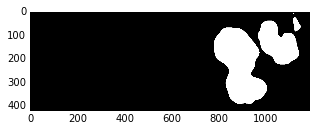

Number of regions generated at level 7 = 95 with dimension 256 x 256 x 3.
Template 1 out of 2
Template 2 out of 2


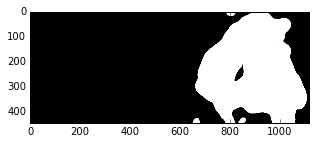

Image 9 with score of 3, percScore of 70. Region sizes generated 256.


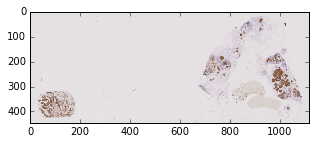

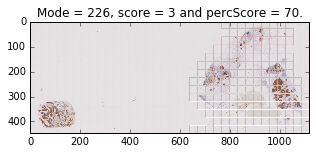

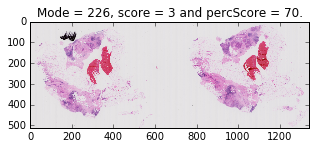

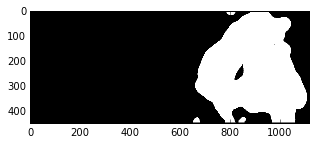

Number of regions generated at level 7 = 160 with dimension 256 x 256 x 3.
Template 1 out of 3
Template 2 out of 3
Template 3 out of 3


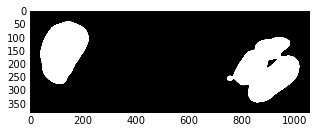

Image 11 with score of 3, percScore of 90. Region sizes generated 256.


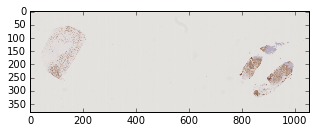

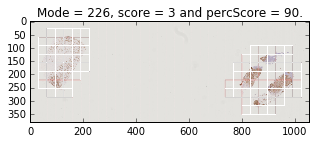

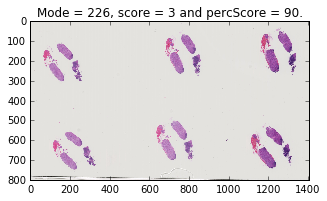

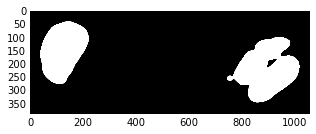

Number of regions generated at level 7 = 95 with dimension 256 x 256 x 3.
Template 1 out of 1


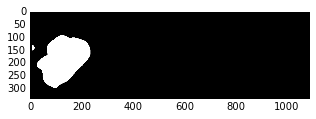

Image 12 with score of 1, percScore of 5. Region sizes generated 256.


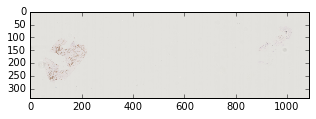

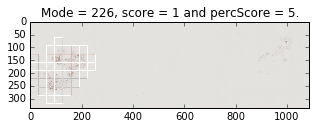

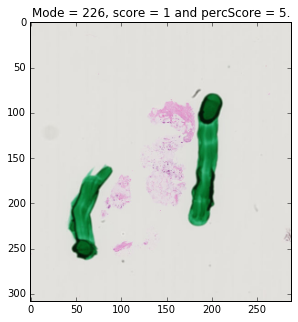

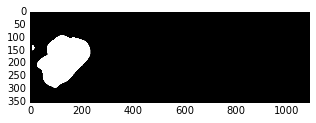

Number of regions generated at level 7 = 38 with dimension 256 x 256 x 3.
Template 1 out of 2
Template 2 out of 2


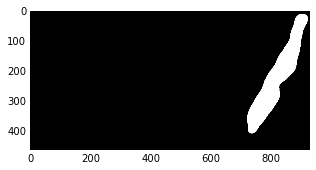

Image 13 with score of 0, percScore of 0. Region sizes generated 256.


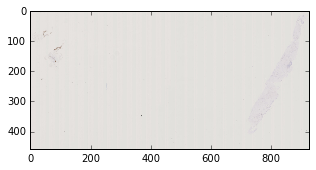

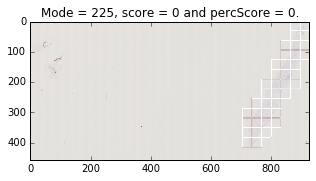

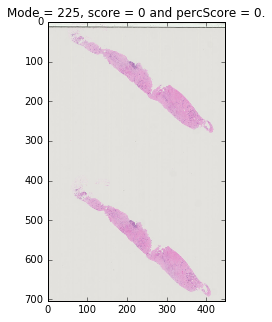

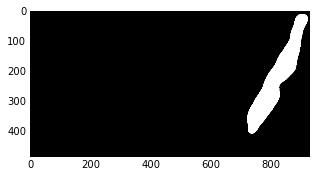

Number of regions generated at level 7 = 39 with dimension 256 x 256 x 3.
Template 1 out of 3
Template 2 out of 3
Template 3 out of 3


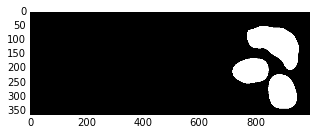

Image 14 with score of 1, percScore of 1. Region sizes generated 256.


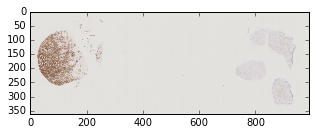

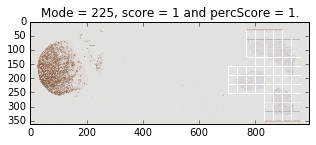

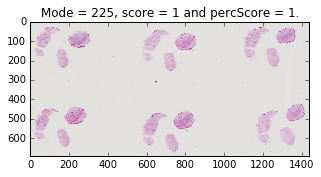

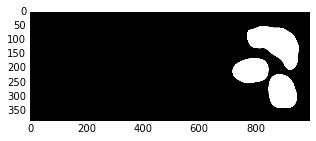

Number of regions generated at level 7 = 57 with dimension 256 x 256 x 3.
Template 1 out of 1


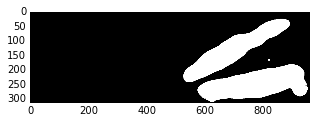

Image 15 with score of 1, percScore of 2. Region sizes generated 256.


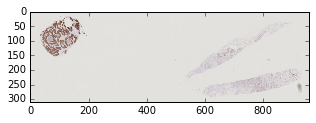

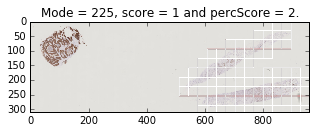

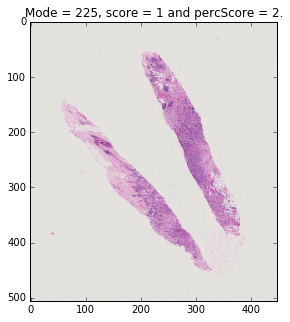

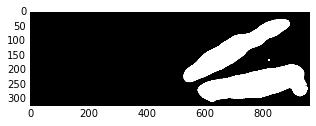

Number of regions generated at level 7 = 85 with dimension 256 x 256 x 3.
Template 1 out of 2
Template 2 out of 2


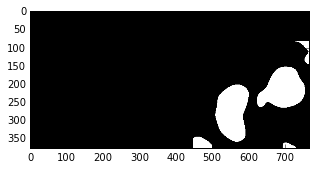

Image 16 with score of 1, percScore of 5. Region sizes generated 256.


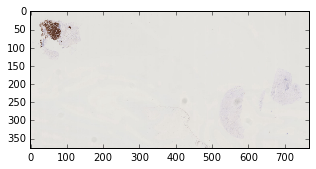

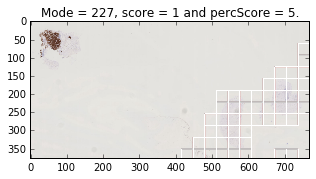

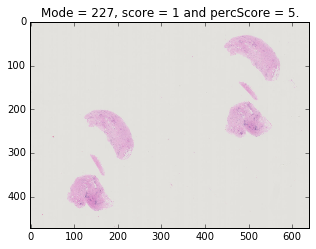

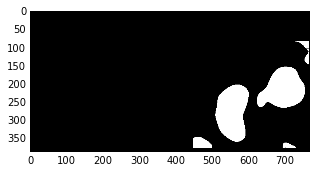

Number of regions generated at level 7 = 48 with dimension 256 x 256 x 3.
Template 1 out of 2
Template 2 out of 2


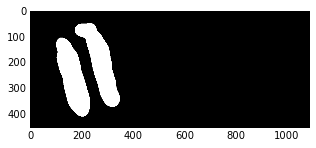

Image 18 with score of 0, percScore of 0. Region sizes generated 256.


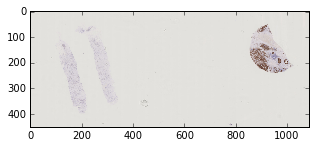

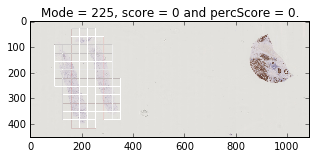

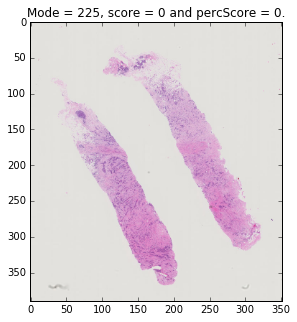

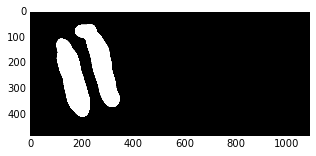

Number of regions generated at level 7 = 70 with dimension 256 x 256 x 3.
Template 1 out of 2
Template 2 out of 2


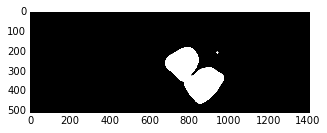

Image 19 with score of 3, percScore of 30. Region sizes generated 256.


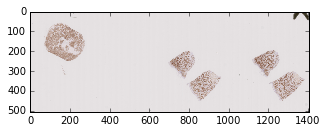

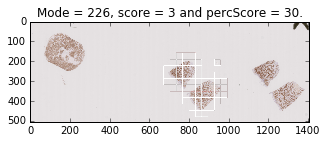

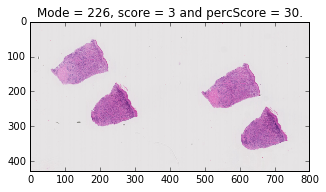

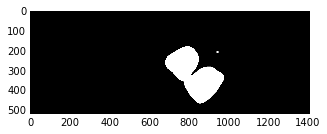

Number of regions generated at level 7 = 61 with dimension 256 x 256 x 3.
Template 1 out of 3
Template 2 out of 3
Template 3 out of 3


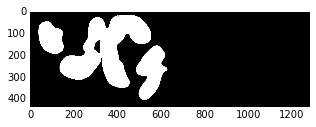

Image 22 with score of 3, percScore of 90. Region sizes generated 256.


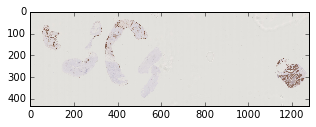

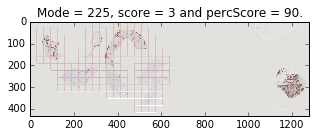

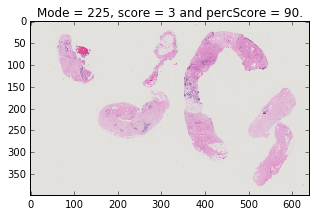

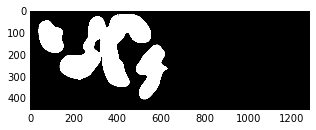

Number of regions generated at level 7 = 149 with dimension 256 x 256 x 3.
Template 1 out of 2
Template 2 out of 2


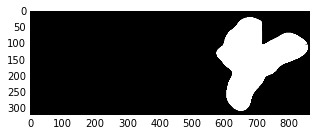

Image 24 with score of 1, percScore of 5. Region sizes generated 256.


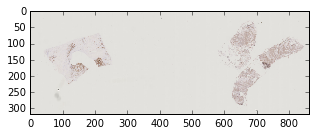

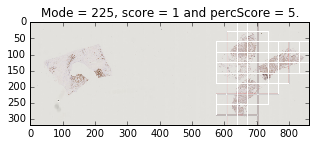

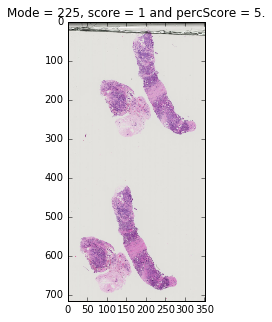

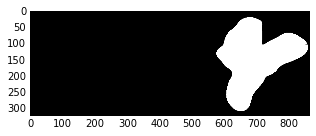

Number of regions generated at level 7 = 57 with dimension 256 x 256 x 3.
Template 1 out of 2
Template 2 out of 2


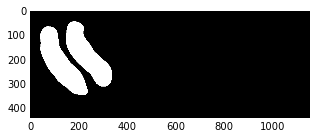

Image 25 with score of 2, percScore of 30. Region sizes generated 256.


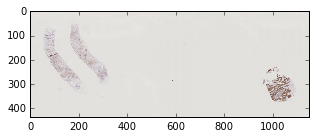

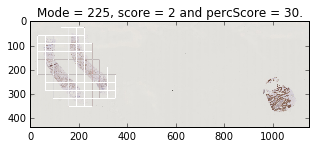

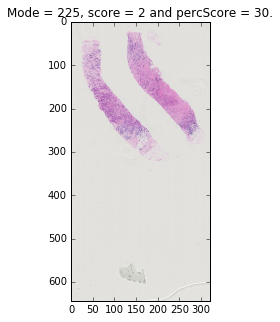

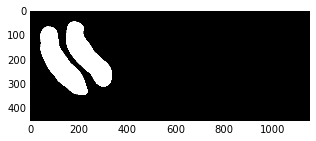

Number of regions generated at level 7 = 69 with dimension 256 x 256 x 3.
Template 1 out of 2
Template 2 out of 2


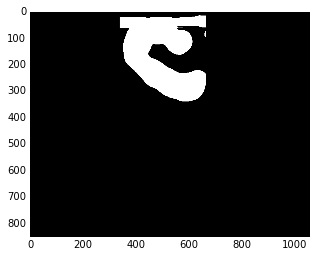

Image 26 with score of 2, percScore of 50. Region sizes generated 256.


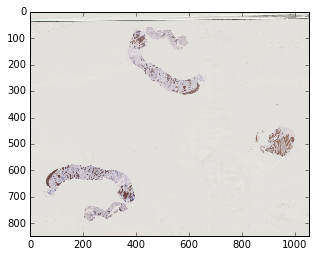

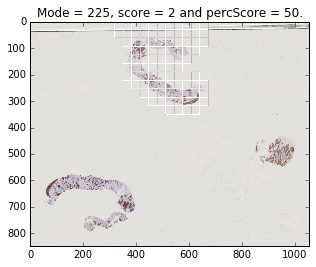

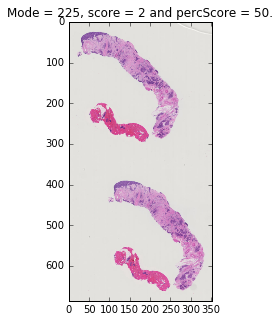

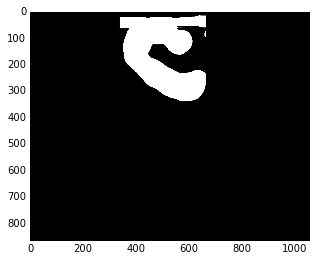

Number of regions generated at level 7 = 88 with dimension 256 x 256 x 3.
Template 1 out of 2
Template 2 out of 2


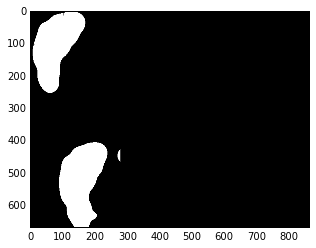

Image 27 with score of 3, percScore of 80. Region sizes generated 256.


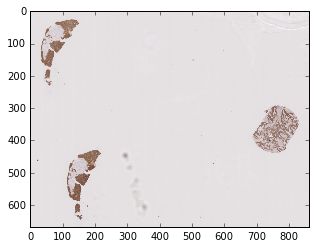

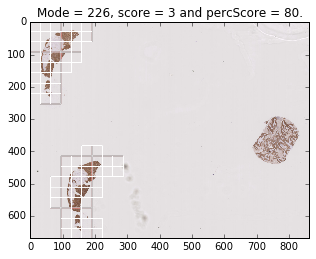

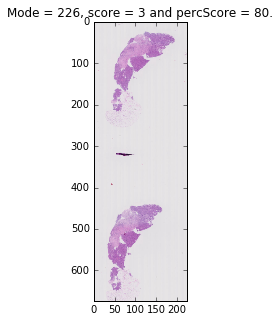

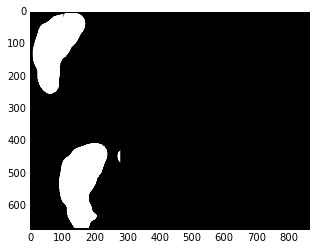

Number of regions generated at level 7 = 72 with dimension 256 x 256 x 3.
Template 1 out of 1


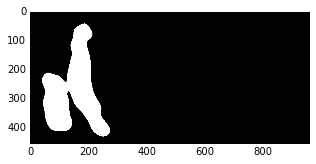

Image 29 with score of 0, percScore of 0. Region sizes generated 256.


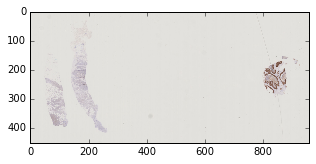

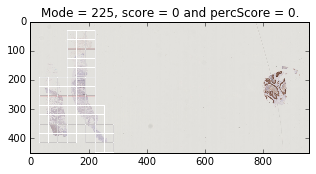

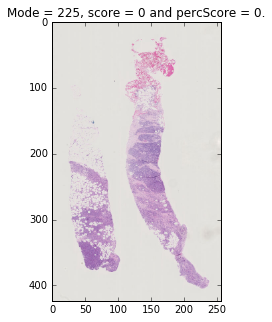

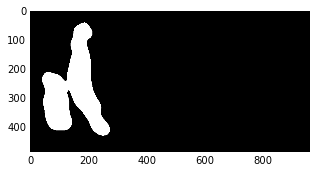

Number of regions generated at level 7 = 64 with dimension 256 x 256 x 3.
Template 1 out of 1


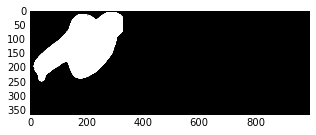

Image 30 with score of 3, percScore of 90. Region sizes generated 256.


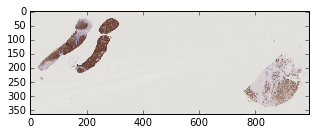

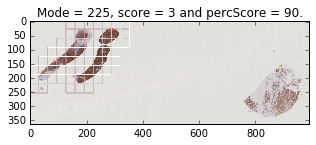

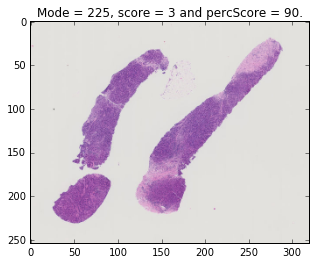

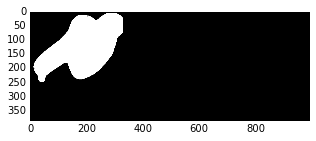

Number of regions generated at level 7 = 61 with dimension 256 x 256 x 3.
Template 1 out of 2
Template 2 out of 2


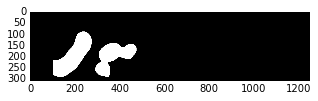

Image 32 with score of 1, percScore of 3. Region sizes generated 256.


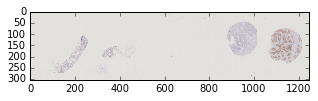

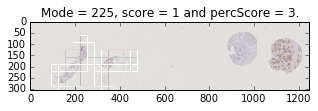

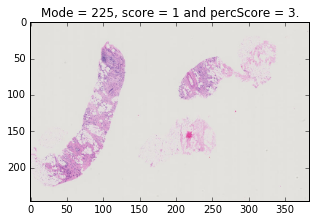

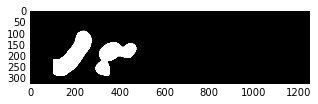

Number of regions generated at level 7 = 50 with dimension 256 x 256 x 3.
Template 1 out of 2
Template 2 out of 2


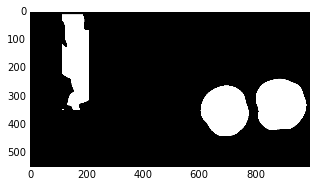

Image 33 with score of 3, percScore of 100. Region sizes generated 256.


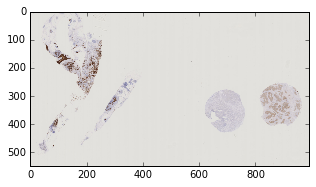

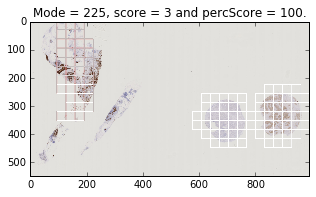

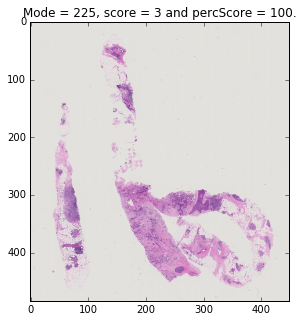

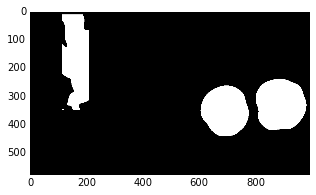

Number of regions generated at level 7 = 108 with dimension 256 x 256 x 3.
Template 1 out of 2
Template 2 out of 2


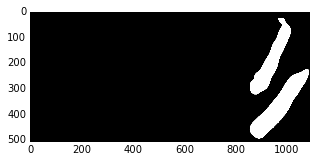

Image 34 with score of 1, percScore of 2. Region sizes generated 256.


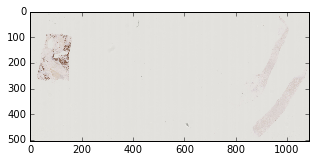

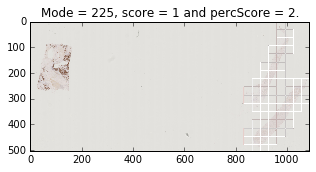

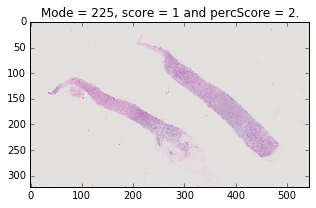

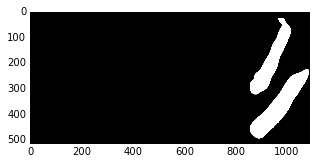

Number of regions generated at level 7 = 61 with dimension 256 x 256 x 3.
Template 1 out of 2
Template 2 out of 2


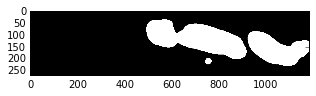

Image 35 with score of 3, percScore of 90. Region sizes generated 256.


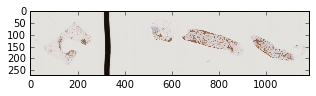

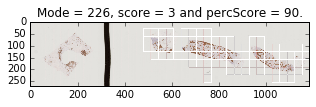

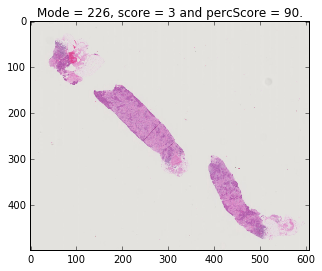

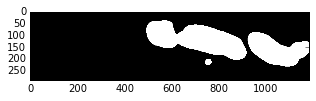

Number of regions generated at level 7 = 92 with dimension 256 x 256 x 3.
Template 1 out of 2
Template 2 out of 2


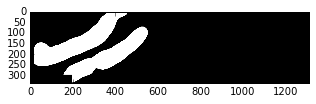

Image 36 with score of 2, percScore of 100. Region sizes generated 256.


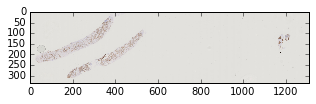

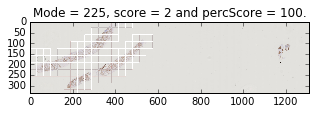

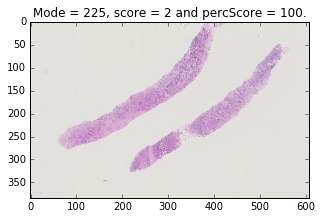

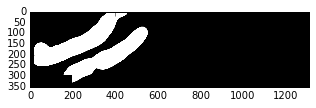

Number of regions generated at level 7 = 100 with dimension 256 x 256 x 3.
Template 1 out of 1


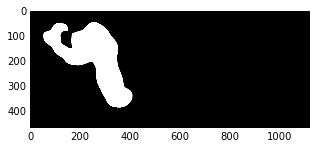

Image 38 with score of 3, percScore of 90. Region sizes generated 256.


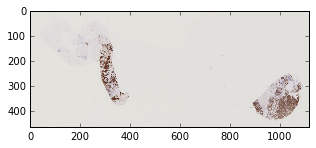

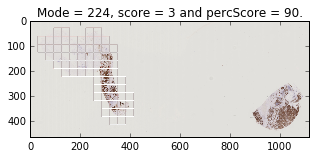

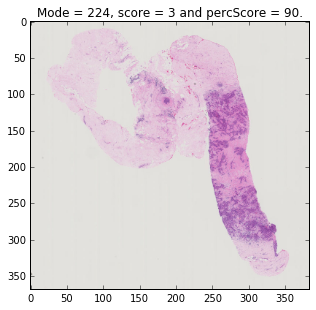

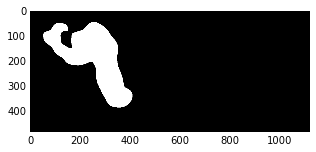

Number of regions generated at level 7 = 69 with dimension 256 x 256 x 3.
Template 1 out of 3
Template 2 out of 3
Template 3 out of 3


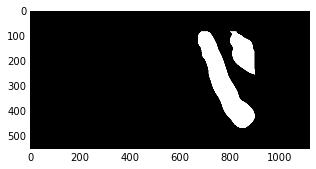

Image 39 with score of 0, percScore of 0. Region sizes generated 256.


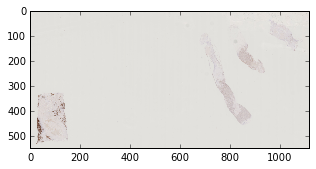

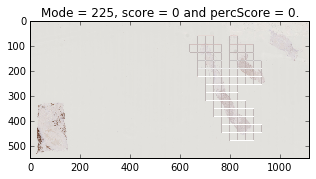

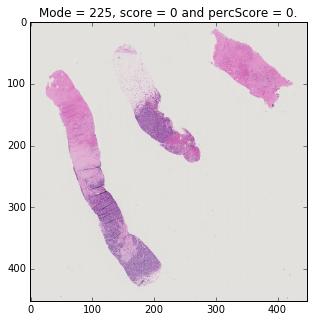

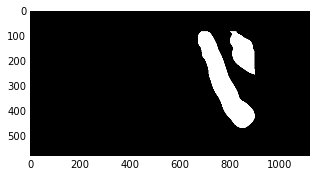

Number of regions generated at level 7 = 66 with dimension 256 x 256 x 3.
Template 1 out of 2
Template 2 out of 2


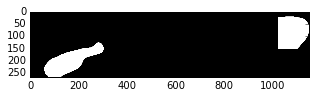

Image 40 with score of 2, percScore of 60. Region sizes generated 256.


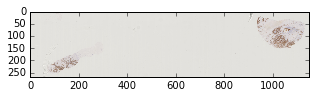

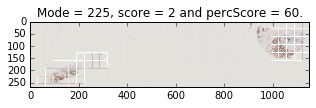

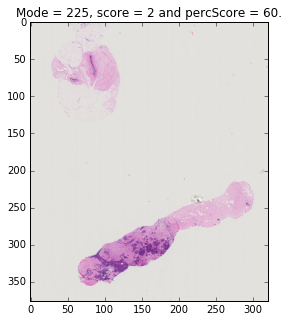

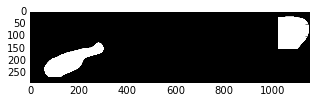

Number of regions generated at level 7 = 48 with dimension 256 x 256 x 3.
Template 1 out of 1


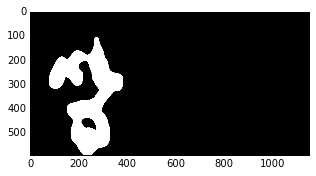

Image 46 with score of 0, percScore of 0. Region sizes generated 256.


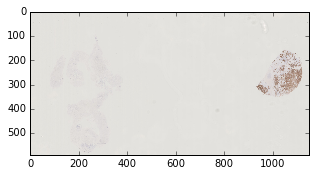

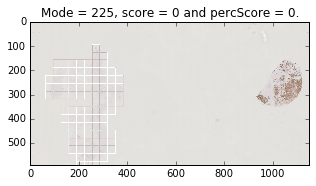

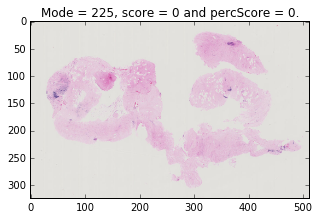

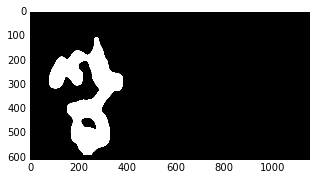

Number of regions generated at level 7 = 94 with dimension 256 x 256 x 3.
Template 1 out of 2
Template 2 out of 2


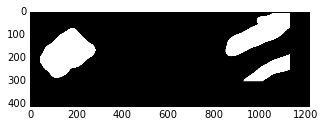

Image 47 with score of 1, percScore of 5. Region sizes generated 256.


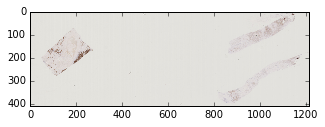

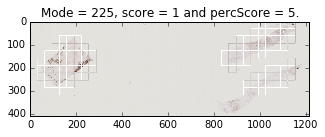

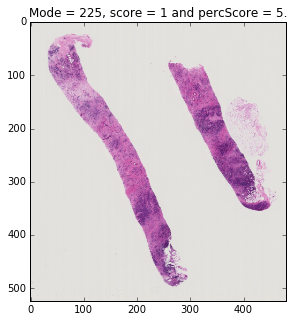

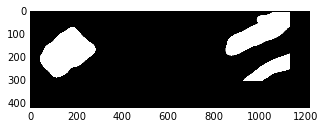

Number of regions generated at level 7 = 103 with dimension 256 x 256 x 3.
Template 1 out of 2
Template 2 out of 2


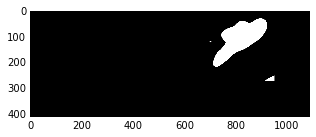

Image 48 with score of 2, percScore of 20. Region sizes generated 256.


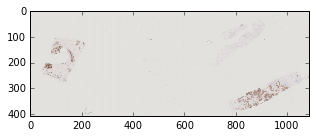

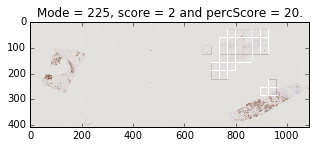

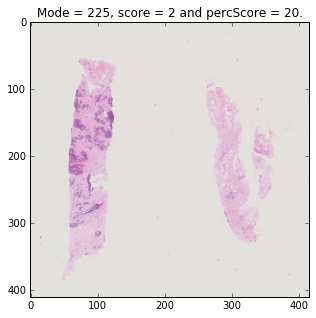

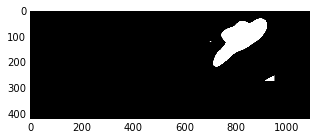

Number of regions generated at level 7 = 30 with dimension 256 x 256 x 3.
Template 1 out of 2
Template 2 out of 2


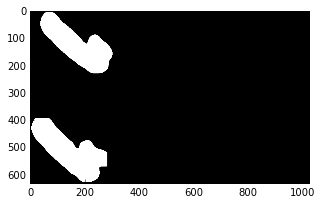

Image 49 with score of 2, percScore of 30. Region sizes generated 256.


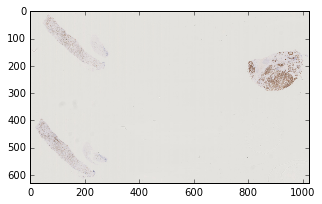

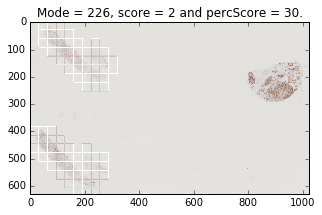

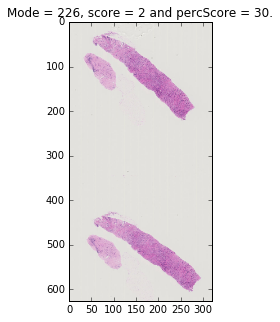

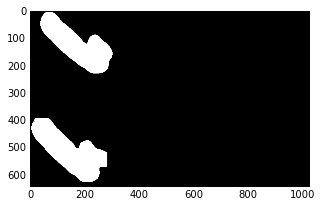

Number of regions generated at level 7 = 81 with dimension 256 x 256 x 3.
Template 1 out of 3
Template 2 out of 3
Template 3 out of 3


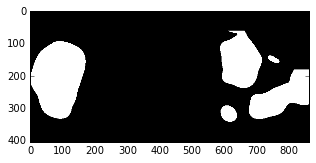

Image 50 with score of 2, percScore of 50. Region sizes generated 256.


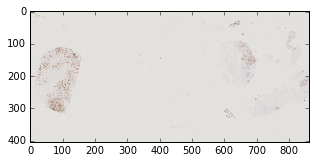

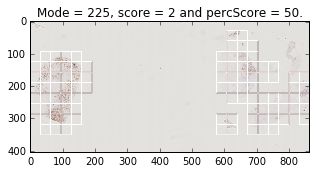

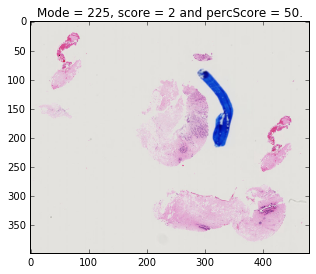

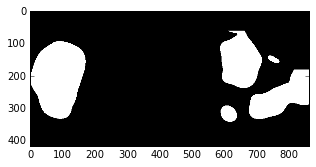

Number of regions generated at level 7 = 94 with dimension 256 x 256 x 3.
Template 1 out of 1


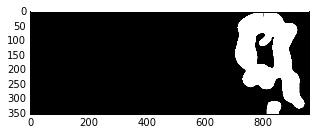

Image 52 with score of 0, percScore of 0. Region sizes generated 256.


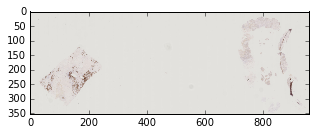

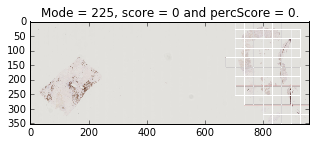

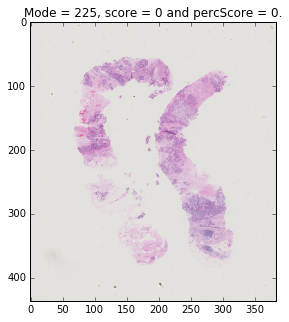

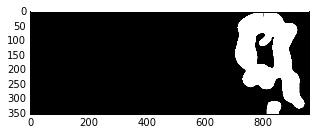

Number of regions generated at level 7 = 67 with dimension 256 x 256 x 3.
Template 1 out of 2
Template 2 out of 2


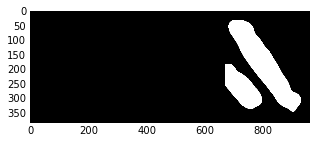

Image 55 with score of 2, percScore of 70. Region sizes generated 256.


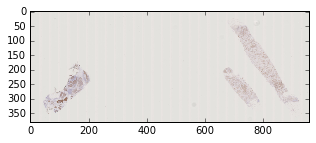

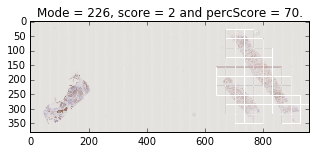

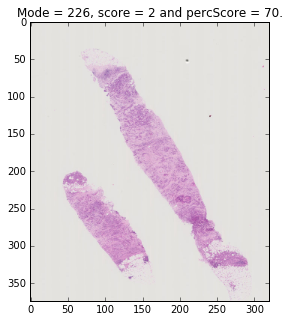

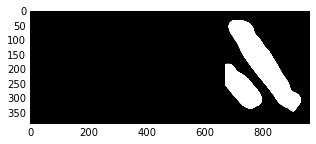

Number of regions generated at level 7 = 59 with dimension 256 x 256 x 3.
Template 1 out of 1


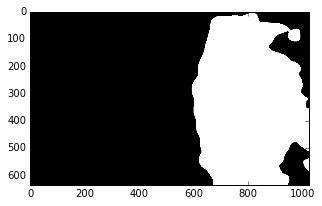

Image 57 with score of 0, percScore of 0. Region sizes generated 256.


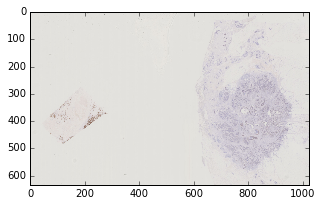

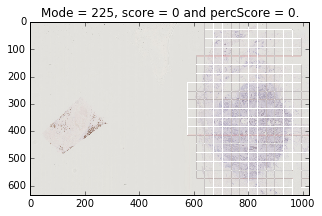

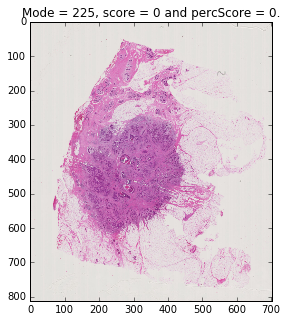

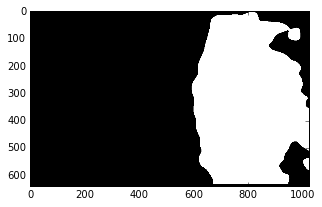

Number of regions generated at level 7 = 238 with dimension 256 x 256 x 3.
Template 1 out of 1


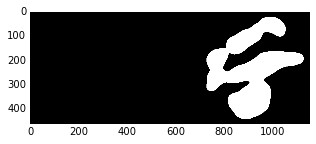

Image 58 with score of 1, percScore of 5. Region sizes generated 256.


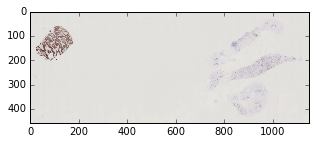

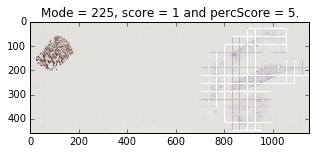

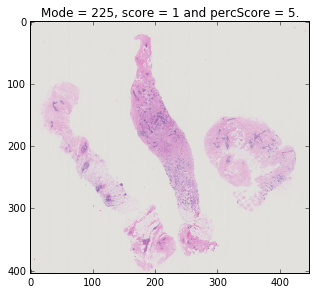

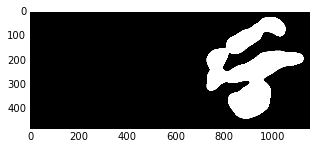

Number of regions generated at level 7 = 108 with dimension 256 x 256 x 3.
Template 1 out of 3
Template 2 out of 3
Template 3 out of 3


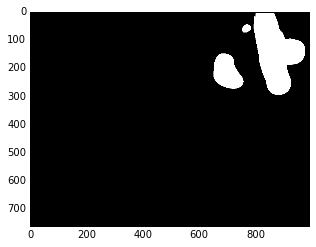

Image 61 with score of 3, percScore of 90. Region sizes generated 256.


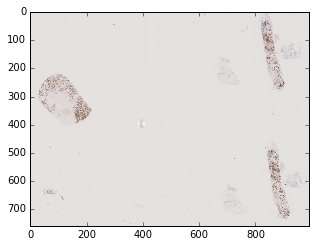

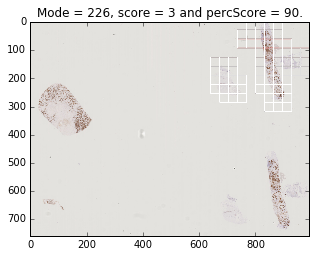

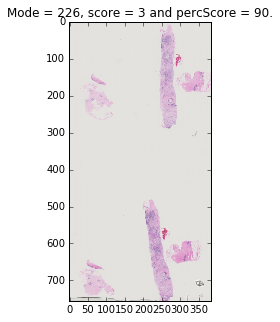

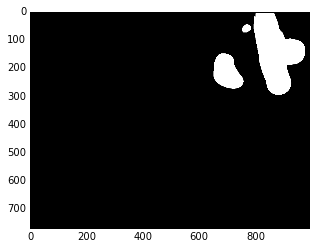

Number of regions generated at level 7 = 64 with dimension 256 x 256 x 3.
Template 1 out of 4
Template 2 out of 4
Template 3 out of 4
Template 4 out of 4


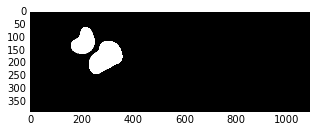

Image 63 with score of 2, percScore of 70. Region sizes generated 256.


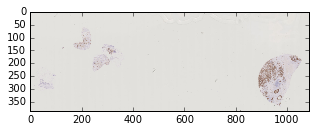

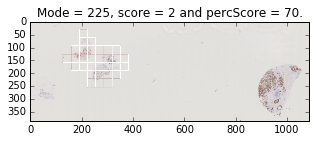

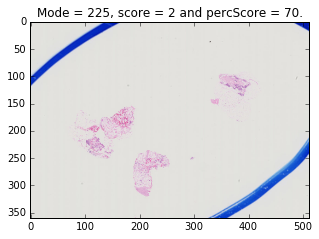

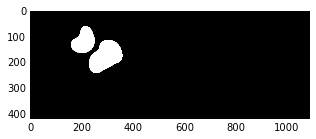

Number of regions generated at level 7 = 31 with dimension 256 x 256 x 3.
Template 1 out of 1


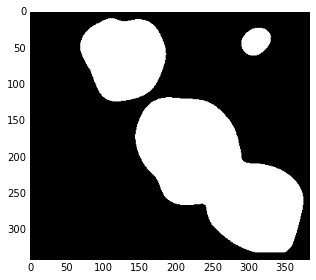

Image 65 with score of 1, percScore of 2. Region sizes generated 256.


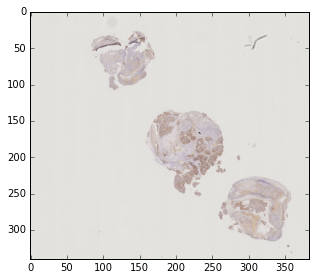

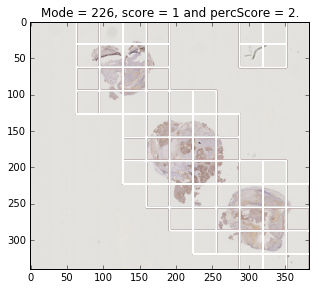

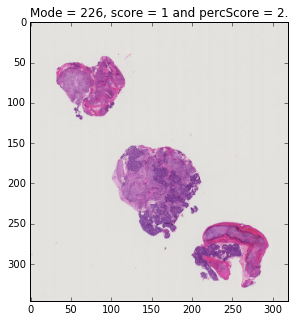

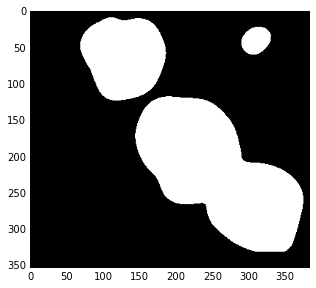

Number of regions generated at level 7 = 60 with dimension 256 x 256 x 3.
Template 1 out of 1


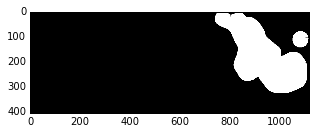

Image 66 with score of 0, percScore of 0. Region sizes generated 256.


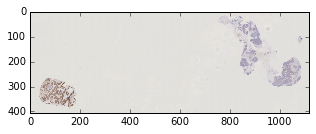

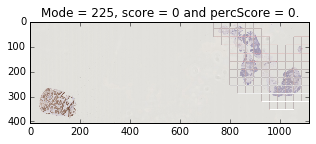

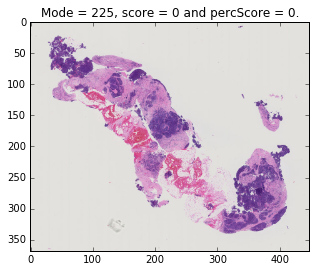

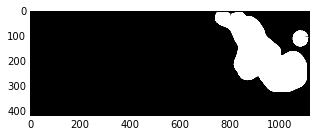

Number of regions generated at level 7 = 85 with dimension 256 x 256 x 3.
Template 1 out of 1


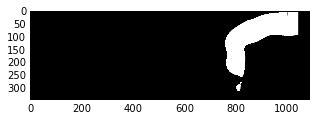

Image 67 with score of 2, percScore of 30. Region sizes generated 256.


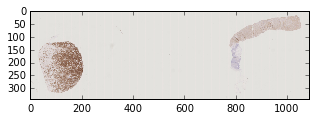

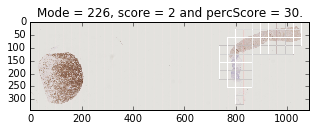

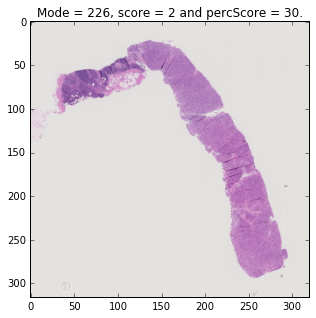

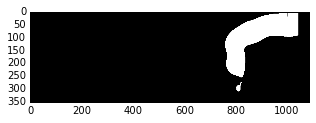

Number of regions generated at level 7 = 49 with dimension 256 x 256 x 3.
Template 1 out of 2
Template 2 out of 2


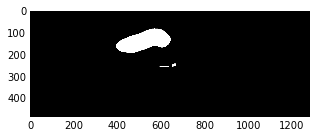

Image 68 with score of 0, percScore of 0. Region sizes generated 256.


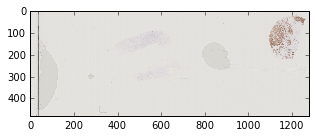

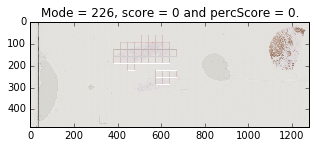

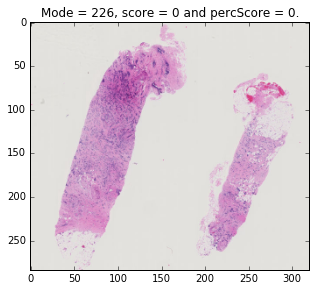

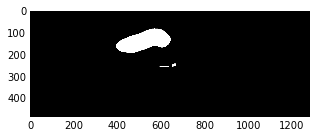

Number of regions generated at level 7 = 33 with dimension 256 x 256 x 3.
Template 1 out of 1


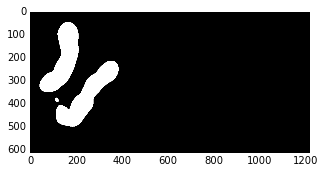

Image 70 with score of 0, percScore of 0. Region sizes generated 256.


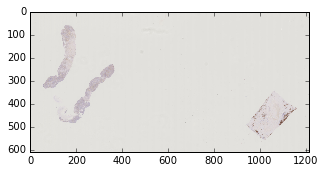

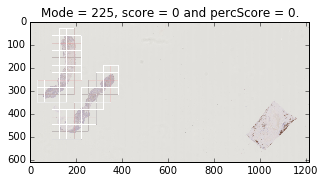

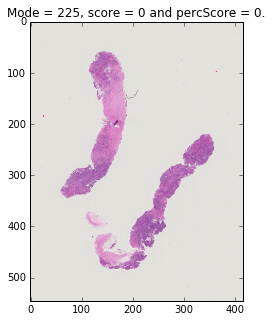

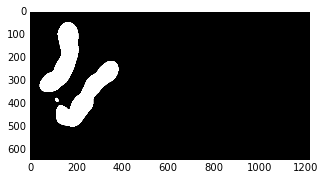

Number of regions generated at level 7 = 83 with dimension 256 x 256 x 3.
Template 1 out of 2
Template 2 out of 2


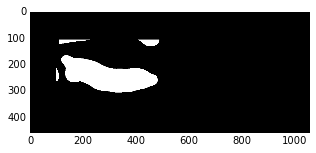

Image 73 with score of 0, percScore of 0. Region sizes generated 256.


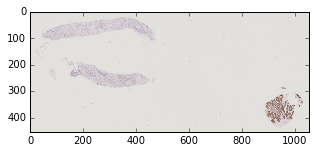

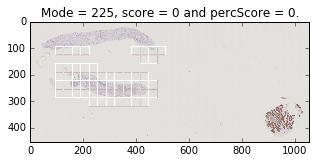

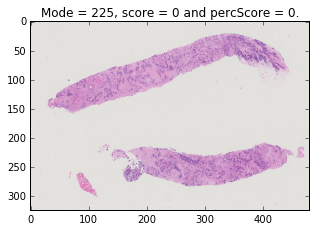

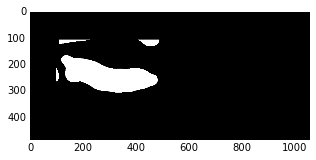

Number of regions generated at level 7 = 57 with dimension 256 x 256 x 3.
Template 1 out of 1


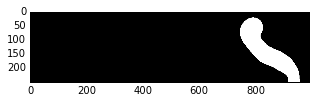

Image 74 with score of 2, percScore of 10. Region sizes generated 256.


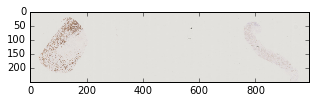

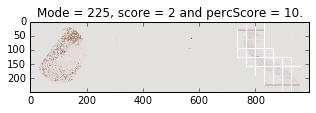

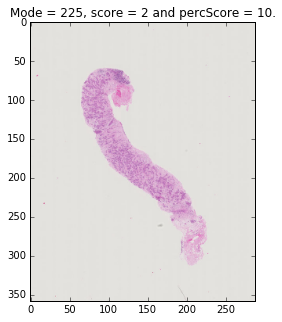

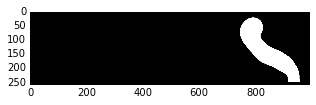

Number of regions generated at level 7 = 28 with dimension 256 x 256 x 3.
Template 1 out of 1


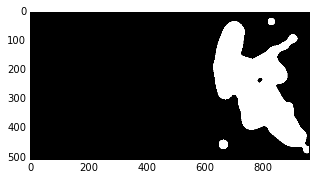

Image 79 with score of 1, percScore of 5. Region sizes generated 256.


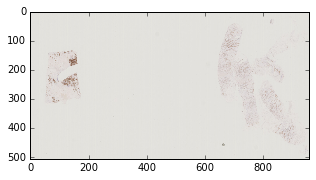

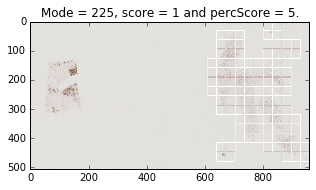

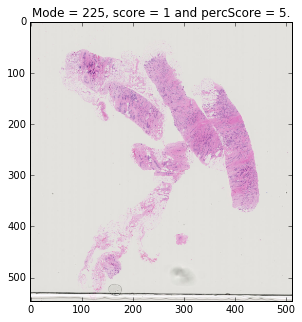

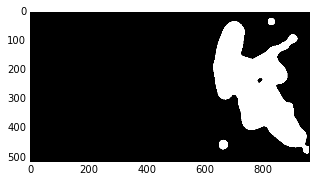

Number of regions generated at level 7 = 105 with dimension 256 x 256 x 3.
Template 1 out of 2
Template 2 out of 2


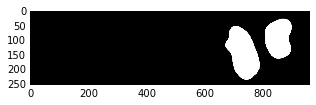

Image 82 with score of 3, percScore of 80. Region sizes generated 256.


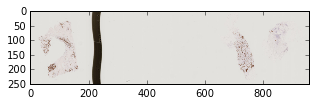

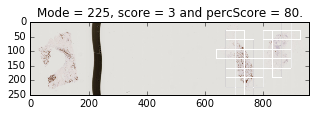

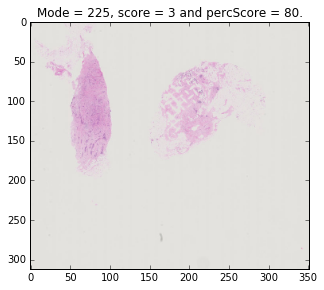

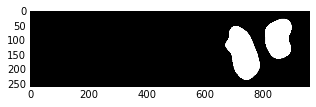

Number of regions generated at level 7 = 39 with dimension 256 x 256 x 3.
Template 1 out of 2
Template 2 out of 2


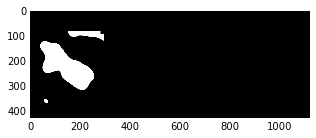

Image 83 with score of 3, percScore of 100. Region sizes generated 256.


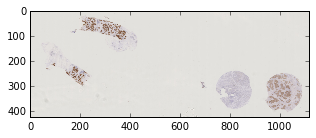

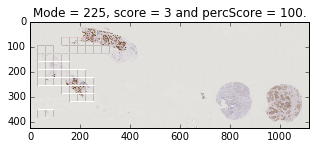

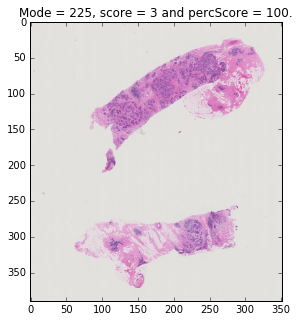

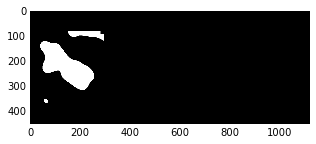

Number of regions generated at level 7 = 42 with dimension 256 x 256 x 3.
Template 1 out of 2
Template 2 out of 2


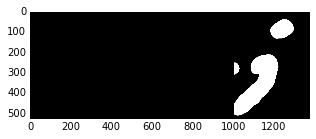

Image 84 with score of 3, percScore of 70. Region sizes generated 256.


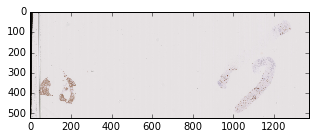

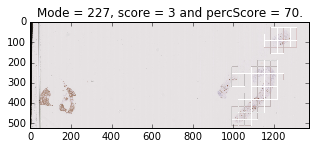

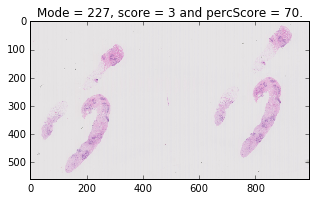

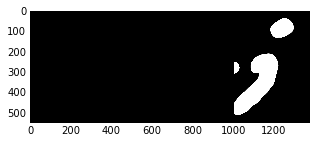

Number of regions generated at level 7 = 64 with dimension 256 x 256 x 3.
Template 1 out of 2
Template 2 out of 2


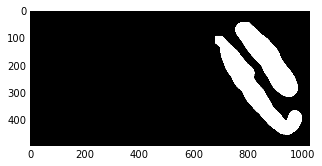

Image 86 with score of 1, percScore of 3. Region sizes generated 256.


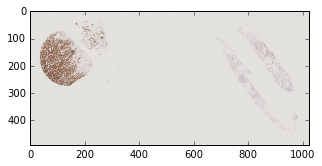

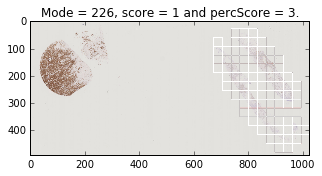

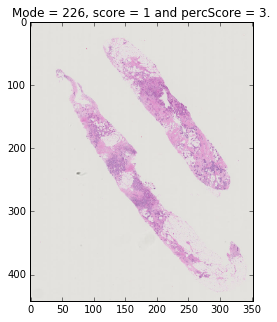

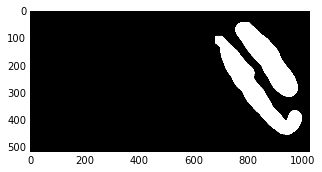

Number of regions generated at level 7 = 85 with dimension 256 x 256 x 3.
Template 1 out of 1


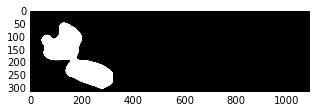

Image 87 with score of 0, percScore of 0. Region sizes generated 256.


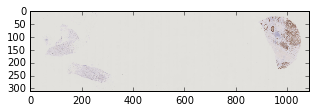

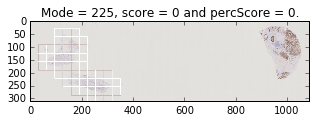

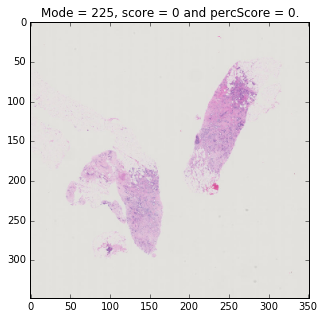

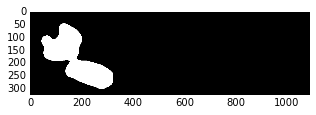

Number of regions generated at level 7 = 48 with dimension 256 x 256 x 3.
Template 1 out of 1


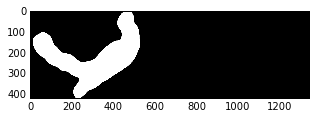

Image 88 with score of 1, percScore of 5. Region sizes generated 256.


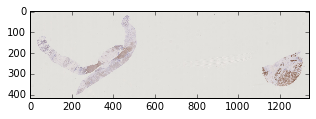

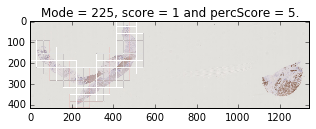

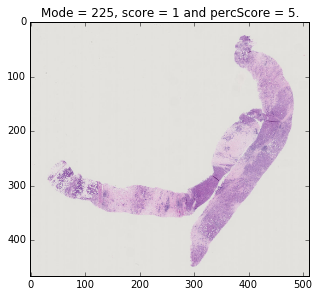

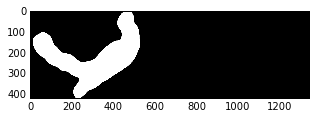

Number of regions generated at level 7 = 99 with dimension 256 x 256 x 3.
('Smallest y: ', 256)
('Smallets x: ', 256)
('Biggest y: ', 256)
('Biggest x: ', 256)
('Number of regions generated: ', [62, 62, 95, 160, 95, 38, 39, 57, 85, 48, 70, 61, 149, 57, 69, 88, 72, 64, 61, 50, 108, 61, 92, 100, 69, 66, 48, 94, 103, 30, 81, 94, 67, 59, 238, 108, 64, 31, 60, 85, 49, 33, 83, 57, 28, 105, 39, 42, 64, 85, 48, 99])


In [12]:
if __name__ == "__main__":


    for upscaleLevel in upscaleLevels: # For each level
       
        upscaleWindowSize = np.power(2,12-upscaleLevel)
        print("==="*40)
        print("Upscale level %d" %upscaleLevel)
        print("==="*40)

        # Dimensions check
        dims = []

        # Generate ROIs and saave jpg
        for caseNo in groundTruth.CaseNo.values[:]:

            nRegions = 0

            newpath = writePath + "roi_" + str(caseNo)  + "/" + str(upscaleLevel) + "/"
            if save == 1:
                removeFiles(newpath)
                if not os.path.exists(newpath):
                    os.makedirs(newpath)

            eg = her2Image(caseNo,threshArea,threshMargin,upscaleWindowSize,upscaleLevel,blackThresh,blurSize,train,method)
            print("==="*40)
            print("==="*40)
            print("Image %d with score of %d, percScore of %d. Region sizes generated %d." % (caseNo,eg.score,eg.percScore,upscaleWindowSize))
            plt.imshow(eg.lowResRGB)
            plt.show()
            #plt.imshow(eg.lowResRGBHE)
            #plt.show()
            regions = eg.regionGen(upscaleLevel) # region object
            regionNo = 0
            caseDims = [] 
            for region in regions:
                nRegions += 1
                if np.random.uniform() < displayProb and show == 1:
                    plt.imshow(region)
                    plt.show()
                if save == 1:
                    region = region[:,:,:3] # remove alpha
                    region = region[:,:,::-1] # swap rgb
                    cv2.imwrite(newpath + str(regionNo) + ".jpg",region)
                regionNo += 1
                caseDims.append(region.shape)
                #print("All alpha values == 255? %r" % np.all(region[:,:,3]==255))

            dims.append(caseDims)
            eg.show()
            numberOfRegions.append(nRegions)
            print("Number of regions generated at level %d = %d with dimension %d x %d x 3." % (eg.level,nRegions,caseDims[0][0],caseDims[0][1]))

    print("Smallest y: ", min([x[0][0] for x in dims]))
    print("Smallets x: ", min([x[0][1] for x in dims]))

    print("Biggest y: ", max([x[0][0] for x in dims]))
    print("Biggest x: ", max([x[0][1] for x in dims]))

    print("Number of regions generated: ",numberOfRegions)

# For filter model

In [ ]:
def filterModelImages():
    filePaths = []
    for filePath in glob.glob("/home/msmith/her2/filter/data/*/*/*.jpg"):
        filePaths.append(filePath)
    pd.DataFrame(filePaths).to_csv("filterDataExtra.csv")